In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import utils
from ImageMatcher import ImageMatcher, ImagePair
import h5py
from scipy.spatial.transform import Rotation as Rot
import cv2
import matplotlib.pyplot as plt
from lk_track import PointTracker, Track
from pathlib import Path
import subprocess
from glob import glob

In [4]:
DATA_DIR = '/Users/richard/Desktop/Motorized-Dataset/'
TRAJ_DIR = DATA_DIR

in_vid_paths = sorted(glob(DATA_DIR + '*.mp4'))

in_vid_path = in_vid_paths[6]
in_vid_stem = Path(in_vid_path).stem

In [34]:
frames = utils.load_video(in_vid_path,
                          grayscale=True)
masks = np.load(DATA_DIR + in_vid_stem + '-masks.npz')['masks']

print('Using video:', in_vid_stem)
print('n_frames:', len(frames))

kf_interval = 30
matcher = ImageMatcher(frames, human_masks=masks, keyframe_interval=kf_interval)

Using video: t008-v04
n_frames: 900


In [ ]:
idx = 690
plt.imshow(frames[idx], 'gray')
plt.imshow(matcher.human_masks[idx], alpha=0.5, cmap='jet')
plt.show()

In [ ]:
p = matcher.match(735, 736, 'orb',
                    min_match_count=25)
print(np.mean(matcher.human_masks[idx]))
print(f'Number of matches: {len(p.src_pts)}')
utils.visualize_matches(p)

In [40]:
image_pairs = []
closures = []

# Find loop closures
if False:
    for i in range(0, len(frames) - kf_interval, kf_interval):
        for j in range(i + kf_interval, len(frames), kf_interval):
            if matcher.sift_kds[i] is None or matcher.sift_kds[j] is None:
                continue
            p = matcher.match(i, j, 'sift',
                            min_match_count=25)
            if p is None:
                continue
            closures.append(p)
            image_pairs.append(p)

if True:
    for i in range(0, len(frames) - 1):
        p = matcher.match(
            i, i+1,
            min_match_count=60,
            ransac_max_iters=2000,
            #keep_percent=0.5,
            verbose=True,
        )
        if p is None:
            print('No match found for frames', i, i+1)
        image_pairs.append(p)

print('Number of loop closures:', len(closures))

closure_residuals_cnt = 0
for p in closures:
    closure_residuals_cnt += len(p.src_pts)
print('Number closure residuals:', closure_residuals_cnt)

print('Total number of image pairs:', len(image_pairs))

utils.export_image_pairs(DATA_DIR + in_vid_stem + '-pairs.h5', image_pairs)

Number of loop closures: 0
Number closure residuals: 0
Total number of image pairs: 899


In [11]:
filtered_closures = []
for p in closures:
    ix = [p.i, p.j]
    if 240 in ix or 750 in ix:
        filtered_closures.append(p)

utils.export_image_pairs(DATA_DIR + in_vid_stem + '-pairs.h5', filtered_closures)

In [ ]:
for p in filtered_closures:
    print(f'Number of matches from {p.i} to {p.j}: {len(p.src_pts)}')
    utils.visualize_matches(p)

In [41]:
opt_cmd = ['../Ceres/build/estimate', DATA_DIR, in_vid_stem + '-pairs.h5']
ret = subprocess.run(opt_cmd)
if ret.returncode != 0:
    print(f'{opt_cmd[0]} exited with non-zero return code!')

Optimizing poses for t008-v04.
Loaded 899 image pairs.
Number of scaled residuals: 0
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.308969e+05    0.00e+00    4.39e+04   0.00e+00   0.00e+00  1.00e+04        0    2.95e-01    5.61e-01
   1  1.098726e+05    2.10e+04    3.49e+04   0.00e+00   2.50e+00  3.00e+04        1    6.27e-01    1.19e+00
   2  9.214727e+04    1.77e+04    2.06e+04   8.78e+02   2.65e+00  9.00e+04        1    4.37e-01    1.62e+00
   3  7.567665e+04    1.65e+04    3.98e+04   1.07e+03   3.02e+00  2.70e+05        1    4.72e-01    2.10e+00
   4  6.315885e+04    1.25e+04    6.09e+04   1.63e+03   2.55e+00  8.10e+05        1    4.51e-01    2.55e+00
   5  5.641390e+04    6.74e+03    8.42e+04   2.69e+03   1.63e+00  2.43e+06        1    4.42e-01    2.99e+00
   6  4.901014e+04    7.40e+03    6.12e+04   2.65e+03   1.81e+00  7.29e+06        1    4.41e-01    3.43e+00
   7  4.497404e+04    4.04e+03    6.19e+04   3.57e+

Using traj:  /Users/richard/Desktop/Motorized-Dataset/t008.npy
angular error mean: 0.80223, max: 2.92125
hfov error mean: 0.25671, max: 1.12449


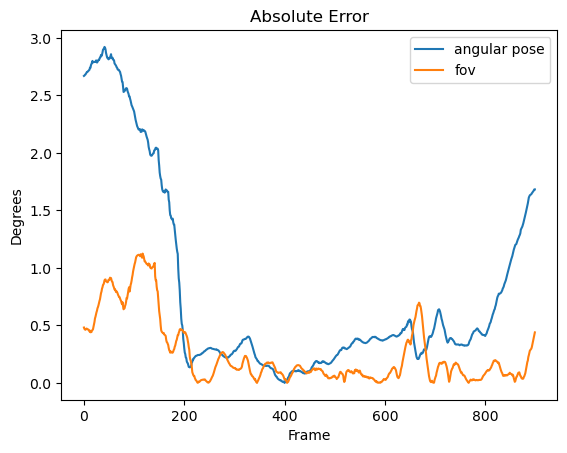

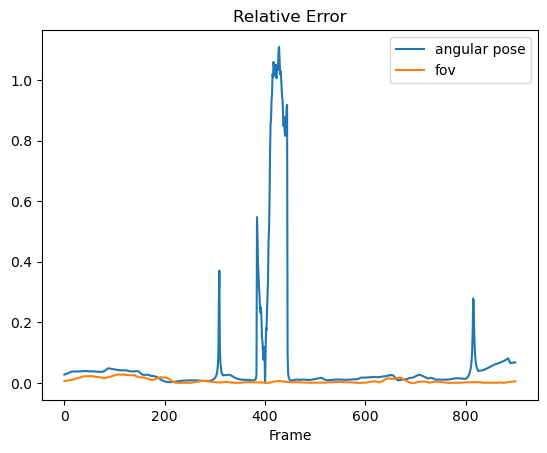

In [48]:
cam_params_raw = utils.import_optimized_cam_params(
    DATA_DIR + in_vid_stem + '-opt-poses.h5')

cam_params = {}
for i, p in cam_params_raw.items():
    cam_params[i] = {
        'R': Rot.from_rotvec(p[:3], degrees=False).as_matrix(),
        'hfov': 2 * np.degrees(np.arctan(320 / p[3])),
    }

traj_path = TRAJ_DIR + f'{in_vid_stem[:4]}.npy'
traj = np.load(traj_path)
print('Using traj: ', traj_path)

cam_params_gt = {}
for i in cam_params.keys():
    p = traj[i]
    cam_params_gt[i] = {
        'R': Rot.from_euler('YXZ', p[:3], degrees=True).as_matrix(),
        'hfov': p[3],
    }

base_idx = sorted(cam_params.keys())[400]

base_R = cam_params[base_idx]['R'].T.copy()
for p in cam_params.values():
    p['R'] = base_R @ p['R']

base_R_gt = cam_params_gt[base_idx]['R'].T.copy()
for p in cam_params_gt.values():
    p['R'] = base_R_gt @ p['R']

# Compute the angular pose error and hfov error between cam_params and cam_params_gt
angular_err_abs = []
angular_err_rel = []
hfov_err_abs = []
hfov_err_rel = []
cam_indices = []

for i in sorted(cam_params.keys()):
    R = cam_params[i]['R']
    R_gt = cam_params_gt[i]['R']

    ae = np.degrees(Rot.from_matrix(R @ R_gt.T).magnitude())
    angular_err_abs.append(ae)
    angular_err_rel.append(ae / max(np.degrees(Rot.from_matrix(R_gt.T).magnitude()), 0.1))

    hfove = np.abs(cam_params[i]['hfov'] - cam_params_gt[i]['hfov'])
    hfov_err_abs.append(hfove)
    hfov_err_rel.append(hfove / cam_params_gt[i]['hfov'])
    cam_indices.append(i)

# pretty print the mean / max of angular and hfov errors to 5 sf
print(f'angular error mean: {np.mean(angular_err_abs):.5f}, '
      f'max: {np.max(angular_err_abs):.5f}')
print(f'hfov error mean: {np.mean(hfov_err_abs):.5f}, max: {np.max(hfov_err_abs):.5f}')

plt.title('Absolute Error')
plt.plot(angular_err_abs, label='angular pose')
plt.plot(hfov_err_abs, label='fov')
plt.xlabel('Frame')
plt.ylabel('Degrees')
plt.legend()
plt.show()

plt.title('Relative Error')
plt.plot(angular_err_rel, label='angular pose')
plt.plot(hfov_err_rel, label='fov')
plt.xlabel('Frame')
plt.legend()
plt.show()


In [49]:
for p in closures:
    print(p.i, p.j)

In [33]:
# print magnitude of GT rotations

for i, p in cam_params_gt.items():
    print(f"Frame {i}: {np.degrees(Rot.from_matrix(p['R']).magnitude()):.5f} degrees")

for p in filtered_closures:
    print(f'LC: {p.i} to {p.j}')

for i, e in angular_err_rel.items():
    print(f'Frame {i} error: {e:.3f}%')

Frame 240: 0.00000 degrees
Frame 270: 0.00000 degrees
Frame 300: 17.97425 degrees
Frame 750: 8.45283 degrees
Frame 780: 8.45283 degrees
Frame 810: 24.53250 degrees
LC: 240 to 270
LC: 240 to 300
LC: 240 to 750
LC: 240 to 780
LC: 240 to 810
LC: 270 to 750
LC: 300 to 750
LC: 750 to 780
LC: 750 to 810
Frame 240 error: 0.000%
Frame 270 error: 0.442%
Frame 300 error: 0.005%
Frame 750 error: 0.102%
Frame 780 error: 0.098%
Frame 810 error: 0.033%
